<div style="text-align: left;">
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>

# Ground-State Calculations with Chemically-Aware Unitary Coupled Cluster

This notebook demonstrates a Hamiltonian Avaraging procedure for a 6-qubit  electronic structure chemistry problem on an H-Series device with the  Chemically-Aware Unitary Coupled Cluster (UCC) Ansatz.

The aim is to estimate the energy of the $\textrm{CH}_4$ molecule. The Hamiltonian Averaging procedure is used to estimate this quantity. 


VQE uses Hamiltonian Averaging, aiming to optimise an initial  parameter set to obtain the lowest energy. In this use case, only one iteration of VQE is executed on  H-Series. The optimal parameters characterising the ground-state of $\textrm{CH}_4$ are obtained from  a noiseless statevector simulator on a classical computer - VQE is performed on a classical computer as  a pre-processing step. These parameters are substituted into the Chemically-Aware UCC circuit. This circuit is then combined with the measurement operations necessary to measure the $\textrm{CH}_4$ Hamiltonian and executed on hardware. 

To minimise the two-qubit gate resources, approximations are made to represent this molecule with 6-qubits. The Chemically Aware UCC Ansatz can be defined with both arbitrary-angle two-qubit gates and fixed-angle two-qubit gates. With arbitrary-angle two-qubit gates, a higher quality output is 
expected.

For further information on Quantinuum's computational chemistry capabilities, please see Quantinuum's premium Python-based R&D platform, [InQuanto](https://www.quantinuum.com/computationalchemistry/inquanto). Capabilities include, but are not limited to, ground-state and excited-state calculations with the proprietary Chemically-Aware UCC method, additional productivity tools to improve result quality, and resource cost for calculations on H-Series.

The $\textrm{CH}_4$ problem was simulated on H-series to estimate (1) optical spectra and (2) a chemical reaction to remove $\textrm{CH}_4$, a greenhouse gas from the atmosphere [Link](https://pubs.aip.org/aip/jcp/article-abstract/158/21/214114/2893956/Chemically-aware-unitary-coupled-cluster-with-ab?redirectedFrom=fulltext).

The following software packages are required by this notebook:


| Package    | Version    |
|------------|------------|
| `pytket`   | v1.22.0    |
| `numpy`    | v1.26.2    |
| `sympy`    | v1.12.0    |
| `pandas`   | v2.1.3     |
| `seaborn`  | v0.13.0    |

### Links

* [InQuanto Chemistry R&D Platform](https://www.quantinuum.com/computationalchemistry/inquanto)
* [Chemically aware unitary coupled cluster with ab initio calculations on an ion trap quantum computer: A refrigerant chemicals’ application](https://pubs.aip.org/aip/jcp/article-abstract/158/21/214114/2893956/Chemically-aware-unitary-coupled-cluster-with-ab?redirectedFrom=fulltext)

## Contents

* [Hamiltonian Specification](#Hamiltonian-Specification)
* [Chemically-Aware UCC Circuit with Fixed-Angle Two-Qubit Gates](#Chemically-Aware-UCC-Circuit-with-Fixed-Angle-Two-Qubit-Gates)
* [Chemically-Aware UCC Circuit with Fixed-Angle Two-Qubit Gates synthesised with `pytket` `PauliExpBox`](#Chemically-Aware-Unitary-Coupled-Cluster-Circuit-with-Fixed-Angle-Two-Qubit-Gates-synthesised-with-`pytket`-`PauliExpBox`)
* [Chemically-Aware UCC Circuit with Arbitrary-Angle Two-Qubit Gates](#Chemically-Aware-UCC-Circuit-with-Arbitrary-Angle-Two-Qubit-Gates)
* [Classical Variational Procedure on Noiseless Statevector Simulator](#Classical-Noiseless-Variational-Procedure-with-NumPy-and-SciPy)
* [Hamiltonian Averaging](#Hamiltonian-Averaging)
* [Jensen-Shannon Divergence](#Jensen-Shannon-Divergence)

## Hamiltonian Specification

First we load in a 6-qubit $\textrm{CH}_4$ Hamiltonian from the `data` subdirectory. The Hamiltonian data is stored in a `json` file. This is loaded into the `QubitPauliOperator` instance using the class method `from_list`.

This Hamiltonian is generated using InQuanto. For more information, please contact <inquanto-support@quantinuum.com>.

In [1]:
import json
from pytket.utils.operators import QubitPauliOperator

json_io = open("data/hamiltonian_ch4_6qb.json", "r")
hamiltonian_data = json.load(json_io)

hamiltonian = QubitPauliOperator.from_list(hamiltonian_data)

## Chemically-Aware UCC Circuit with Fixed-Angle Two-Qubit Gates

The Chemically-Aware UCC state-preparation method for this $\textrm{CH}_4$ consists of applying exponentiated Qubit Pauli operations to a reference input state. Our input state is $| 100000 \rangle$. The aim is to generate the parameteric wavefunction, 

\begin{equation*}
|\psi\rangle = |110000\rangle + \alpha |001100\rangle + \beta |000011\rangle,
\end{equation*}

where $\alpha$ and $\beta$ are related to gate angles on the state-preparation circuit. 

In this problem, four operations are applied, the top equation first and the bottom equation last,
\begin{align*}
e^{+\theta_0 \frac{\pi}{2} \hat{Y}_{q[0]} \hat{X}_{q[2]}}, \\
e^{-\theta_0 \frac{\pi}{2} \hat{X}_{q[0]} \hat{Y}_{q[2]}}, \\
e^{+\theta_1 \frac{\pi}{2} \hat{Y}_{q[0]} \hat{X}_{q[4]}}, \\
e^{-\theta_1 \frac{\pi}{2} \hat{X}_{q[0]} \hat{Y}_{q[4]}}.
\end{align*}

This will generate the state, $|100000\rangle + \alpha |001000\rangle + \beta |000010\rangle$. Subsequently, three `CX` gates can be applied to generate the final target state, $|\psi\rangle$.

This operation can be seen as exciting a pair of electrons from the least energetic spatial orbital to a higher energy spatial orbital. In  this problem, we have three spatial orbitals: one double occupied orbital, and two unoccupied or virtual orbitals. Each even-odd qubit pair  in the circuit corresponds to the spatial orbitals. Each spatial orbital consists of alpha (beta) spin orbitals or spin-up (spin-down) spin-orbitals. If the orbital is occupied, the qubit is toggled to a $|1\rangle$ ($|0\rangle$), the spin-orbital is occupied (unoccupied).

InQuanto provides the Chemically Aware UCC method which can be used to synthesise pytket circuits for electronic structure problems involving single excitations, double excitations, including double excitations of pairs of electrons from spatial orbital to spatial orbital. Additionally, InQuanto uses system specific data, such as point-group symmetry, to improve the number of single and double excitations to synthesise in the state-preparation method.

In the code cell below, the function generates the subcircuit for the  exponentiated operations. For the case of two spatial to spatial double excitations, 4 primitives are required with two symbols, $a$ and $b$. These primitives are returned as `pytket.circuit.CircBox` objects which can be appended onto the `pytket.circuit.Circuit` state-preparation instance.

The primitive defined below is know as the Pauli-gadget primitive. For spatial to spatial double excitations, each Pauli-Gadget requires two `CX` gates.

In [2]:
from pytket.circuit import Circuit, CircBox
from pytket.circuit.display import render_circuit_jupyter
from sympy import Symbol

def YX_primitive(
    symbol: Symbol, 
    reverse: bool = False
) -> Circuit:
    circuit = Circuit(2)

    if reverse:
        circuit.H(0).V(1)
    else:
        circuit.V(0).H(1)

    circuit.CX(0, 1)

    if reverse:
        symbol *= -1
    circuit.Rz(symbol, 1)

    circuit.CX(0, 1)

    if reverse:
        circuit.H(0).Vdg(1)
    else:    
        circuit.Vdg(0).H(1)

    return CircBox(circuit)

In [3]:
symbols = [Symbol("a"), Symbol("b")]
n_qubits = 6

yx_0 = YX_primitive(symbols[0])
xy_0 = YX_primitive(symbols[0], reverse=True)

yx_1 = YX_primitive(symbols[1])
xy_1 = YX_primitive(symbols[1], reverse=True)

In [4]:
render_circuit_jupyter(yx_0.get_circuit())

To map the state, $|100000\rangle + \alpha |001000\rangle + \beta |000010\rangle$, to the final state, $|110000\rangle + \alpha |001100\rangle + \beta |000011\rangle$, three `CX` operations are required. Each of these `CX` gates uses the even qubit as a control and the odd qubit as a target. In prior cells, the concept of spatial orbitals and electrons were introduced. This will now be expanded upon. There are three tuples of qubits, each representing spatial orbitals: 

* (`q[0]`, `q[1]`) 
* (`q[2]`, `q[3]`)
* (`q[4]`, `q[5]`)

The even-index (odd-index) qubit refers to the alpha (beta) spin-orbitals or spin-up (spin-down) orbitals. The purpose of the CX is to toggle the occupation of the beta spin-orbital, if the alpha-spin orbital is occupied.

In [5]:
circuit_cx = Circuit(n_qubits)
circuit_cx.CX(0, 1).CX(2, 3).CX(4, 5)

render_circuit_jupyter(circuit_cx)

The `pytket.circuit.CircBox` instances will be appended to the circuit encoding the initial state. The extra CX operations will be added last. A `pytket` compilation pass, `pytket.passes.DecomposeBoxes` needs to be used to decompose the appended `pytket.circuit.CircBox` commands on the circuits into native `CX`, `Rz`, `H`, `V` and `Vdg` gates.

In [6]:
from pytket.passes import DecomposeBoxes

decompose_boxes = DecomposeBoxes

In [7]:
circ_fixed = Circuit(n_qubits)
qubits = circ_fixed.qubits

circ_fixed.X(0) # intial state |100000>

circ_fixed.add_circbox(yx_0, [qubits[0], qubits[2]])
circ_fixed.add_circbox(xy_0, [qubits[0], qubits[2]])
circ_fixed.add_circbox(yx_1, [qubits[0], qubits[4]])
circ_fixed.add_circbox(xy_1, [qubits[0], qubits[4]])
circ_fixed.append(circuit_cx)
decompose_boxes().apply(circ_fixed)

True

In [8]:
render_circuit_jupyter(circ_fixed)

## Chemically-Aware Unitary Coupled Cluster Circuit with Fixed-Angle Two-Qubit Gates synthesised with `pytket` `PauliExpBox`

The Chemically-Aware UCC circuit from the previous section can also be synthesised with `PauliExpBox` and `CircBox`. The motivation is to perform [Pauli-Gadget Synthesis](https://arxiv.org/abs/1906.01734) to synthesise the UCC state-preparation circuit. The benefit is that the circuit primitives from the previous section are now automatically created with `pytket` and there are additional savings in fixed-angle two-qubit gates. The user is required to input the Qubit Pauli exponents as a sequence of Paulis (`List[pytket.pauli.Pauli]`) alongside a symbolic parameter.

Each spatial to spatial excitation consists of two exponeniated operations. In the code cell below, this would correspond to two `PauliExpBox` instances with the same symbolic parameter. Each pair of `PauliExpBox` instances belonging to the same excitation is appended to a `pytket.circuit.Circuit` instance and isolated with a `pytket.circuit.CircBox`.

In [9]:
from pytket.circuit import PauliExpBox, Circuit, CircBox, fresh_symbol
from pytket.pauli import Pauli

circ_0_1 = Circuit(2)
yx_0_1 = PauliExpBox([Pauli.Y, Pauli.X], symbols[0])
xy_0_1 = PauliExpBox([Pauli.X, Pauli.Y], -1 * symbols[0])
circ_0_1.add_pauliexpbox(yx_0_1, circ_0_1.qubits).add_pauliexpbox(xy_0_1, circ_0_1.qubits)
circbox_0_1 = CircBox(circ_0_1)

circ_1_1 = Circuit(2)
yx_1_1 = PauliExpBox([Pauli.Y, Pauli.X], symbols[1])
xy_1_1 = PauliExpBox([Pauli.X, Pauli.Y], -1 * symbols[1])
circ_1_1.add_pauliexpbox(yx_1_1, circ_1_1.qubits).add_pauliexpbox(xy_1_1, circ_1_1.qubits)
circbox_1_1 = CircBox(circ_1_1)

In the code cell below, the two `pytket.circuit.CircBox`, each corresponding to two spatial to spatial orbital excitations, is added to a 6-qubit circuit, initialised with the reference state, $|100000\rangle$. Two compilation passes are now applied, `DecomposeBoxes` and `PauliSimp`. The former decomposes CircBox commands on the circuit into one-qubit and fixed-angle two-qubit gates. The latter compilation pass optimises the number of fixed-angle two-qubit gates on the circuit. 

This new circuit contains 2 fixed-angle two-qubit gates per excitation, as opposed to 4 fixed-angle two-qubit gates as in the previous section.

In [10]:
from pytket.passes import GuidedPauliSimp
circ_paulisimp = Circuit(6).X(0) # create reference state |100000>
circ_paulisimp.add_circbox(circbox_0_1, [circ_paulisimp.qubits[0], circ_paulisimp.qubits[2]])
circ_paulisimp.add_circbox(circbox_1_1, [circ_paulisimp.qubits[0], circ_paulisimp.qubits[4]])
GuidedPauliSimp().apply(circ_paulisimp)
circ_paulisimp.append(circuit_cx)

In [11]:
render_circuit_jupyter(circ_paulisimp)

## Chemically-Aware UCC Circuit with Arbitrary-Angle Two-Qubit Gates

The circuits defined above used fixed-angle two-qubit (`CX`) gates. Compiling to the H-Series gateset results in circuits with `pytket.ciruit.OpType.ZZMax` or fully-entangling two-qubit gates. 

In this section, the Chemically-Aware UCC circuit is defined at 6-qubits with an  arbitrary-angle two-qubit gate (`pytket.circuit.OpType.ZZPhase`). This arbitrary-angle  two-qubit gate is a native gate on H-Series and for small angles, offers better fidelity than  the native fixed-angle two-qubit gate.

In the code cell below, a function is defined, requiring a symbol and a boolean as input. The  symbol is the gate angle for the arbitrary-phase two-qubit gate. The boolean keyword argument  dictates whether to synthesise $e^{\theta Y_{q[0]} X_{q[1]}}$ or $e^{\theta X_{q[0]} Y_{q[1]}}$. The output of this function is a `pytket.circuit.CircBox`. As with the previous section, 2 excitations are synthesised, each excitation requiring 2 `pytket.circuit.CircBox` instances.

In [12]:
from pytket.circuit import Circuit, CircBox, OpType

def yx_arbzz_primitive(
    symbol: Symbol, 
    reverse: bool = False
) -> CircBox:
    circ = Circuit(2)
    if reverse:
        i, j = 1, 0
        symbol *= -1
    else:
        i, j = 0, 1
    circ.PhasedX(0.5, 0, i) # V
    circ.PhasedX(0.5, 1.5, j).Rz(1, j) # Hadamard
    circ.ZZPhase(symbol, 0, 1)
    circ.PhasedX(1.5, 0, i) # Vdg
    circ.PhasedX(0.5, 1.5, j).Rz(1, j) # Hadamard
    return CircBox(circ)

In [13]:
yx_0_2 = yx_arbzz_primitive(symbols[0])
xy_0_2 = yx_arbzz_primitive(symbols[0], reverse=True)

yx_1_2 = yx_arbzz_primitive(symbols[1])
xy_1_2 = yx_arbzz_primitive(symbols[1], reverse=True)

In [14]:
render_circuit_jupyter(yx_0_2.get_circuit())

In [15]:
render_circuit_jupyter(xy_0_2.get_circuit())

In [16]:
from pytket.passes import DecomposeBoxes

circ_arbzz = Circuit(6)
qubits = circ_arbzz.qubits
circ_arbzz.X(0) # |100000>

circ_arbzz.add_circbox(yx_0_2, [qubits[0], qubits[2]])
circ_arbzz.add_circbox(xy_0_2, [qubits[0], qubits[2]])
circ_arbzz.add_circbox(yx_1_2, [qubits[0], qubits[4]])
circ_arbzz.add_circbox(xy_1_2, [qubits[0], qubits[4]])
circ_arbzz.append(circuit_cx)

DecomposeBoxes().apply(circ_arbzz)

True

In [17]:
render_circuit_jupyter(circ_arbzz)

## Classical Noiseless Variational Procedure with NumPy and SciPy

Now we perform the variational procedure with numpy and scipy. The pytket objects are converted into numpy arrays. The Hamiltonian can be transformed from a `pytket.utils.operators.QubitPauliOperator` instance into a sparse square matrix. The `pytket.circuit.Circuit` instance can be represented as a complex column vector with $2^N$ elements ($N$ is the number of qubits - for this problem the vector will contain 64 elements). The objective function performs these transformations and evaluates the energy using the numpy dot product function.

`scipy.optimize` is used to optimise the input parameters for the objective function, to obtain the lowest estimate of the ground-state energy.

In [18]:
from typing import List

from sympy import Symbol
import numpy as np

from pytket.utils.operators import QubitPauliOperator
from pytket.circuit import Circuit

class VariationalProcedure:
    def __init__(
        self, 
        operator: QubitPauliOperator,
        state_circuit: Circuit,
        symbols: List[Symbol]
    ):
        self._operator = operator.to_sparse_matrix().toarray()
        self._circuit = state_circuit
        self._symbols = symbols
    
    def __call__(
        self, 
        parameters: np.ndarray
    ) -> float:
        symbol_dict = {s: p for (s, p) in zip(self._symbols, parameters)}
        circuit = self._circuit.copy()
        circuit.symbol_substitution(symbol_dict)
        statevector = circuit.get_statevector()
        energy = np.vdot(statevector, self._operator.dot(statevector))
        return energy.real

In [19]:
variational_procedure_fixed = VariationalProcedure(hamiltonian, circ_fixed, symbols)
variational_procedure_paulisimp = VariationalProcedure(hamiltonian, circ_paulisimp, symbols)
variational_procedure_arbzz = VariationalProcedure(hamiltonian, circ_arbzz, symbols)
initial_parameters = np.zeros(len(symbols))

In [20]:
from scipy.optimize import minimize
result_fixed = minimize(variational_procedure_fixed, initial_parameters, method="L-BFGS-B")
result_paulisimp = minimize(variational_procedure_paulisimp, initial_parameters, method="L-BFGS-B")
result_arbzz = minimize(variational_procedure_arbzz, initial_parameters, method="L-BFGS-B")

In [21]:
import pandas as pd

output = lambda symbols, result: pd.Series([p for p in result.x] + [result.fun], index=symbols+["Energy (Ha)"])
d0 = output(symbols, result_fixed)
d1 = output(symbols, result_paulisimp)
d2 = output(symbols, result_arbzz)

df = pd.concat([d0, d1, d2], axis=1)
df.columns = ["Fixed-Angle", "Fixed-Angle/ Paulisimp", "Arbitrary-Angle"]
df

,Fixed-Angle,Fixed-Angle/ Paulisimp,Arbitrary-Angle
a,0.030655,0.030655,0.030655
b,0.003461,0.003461,0.003461
Energy (Ha),-39.742681,-39.742681,-39.742681


## Hamiltonian Averaging

The following code cells estimate the Hamiltonian Expectation Value using `pytket.utils.expectations.get_operator_expectation_value`. This function performs measurement reduction under the hood to reduce the number of measurement circuits required to estimate the ground-state energy. Circuit submission and result retrieval are also performed internally within this `pytket` convenience function.

This procedure requires the Chemically-Aware UCC state-preparation circuit, the 6-qubit electronic structure Hamiltonian for $\textrm{CH}_4$ and the parameter set characterising the ground-state of $\textrm{CH}_4$.

The H-Series emulator (`H1-2E`) is used for this problem.

In [23]:
from pytket.extensions.quantinuum import QuantinuumBackend

backend = QuantinuumBackend(device_name="H1-2E")
backend.login()

The code-cell below, the `hamiltonian_averaging_submission` requires the following inputs: 

* Chemically Aware UCC state-preparation circuit
* a `QubitPauliOperator` instance of the Hamiltonian
* a dictionary mapping symbols on the circuit to numerical parameters 
* a `QuantinuumBackend` instance
* an integer specifying the number of shots to execute per circuit
* an integer specifying the maximum HQCs to consume before a batch session is terminated
* a boolean specifying whether the circuit should be rebased from `ZZPhase` (after compilation by QuantinuumBackend) to `ZZMax`

This function prepares the measurement circuits needed to perform Hamiltonian Averaging. First the Hamiltonian is decomposed into commuting sets of Pauli-strings. Second, the commuting sets are synthesised into measurement operations, which are appended onto a copy of the Chemically-Aware UCC circuit (with numerical parameters). The circuits are submitted under the same batch session.

A second function, `hamiltonian_averaging_evaluate`, retrieves the result and performs the appropriate post-processing to evaluate the expectation value of the Hamiltonian. If the parameters corresponding to the approximate ground-state are inputted into `hamiltonian_averaging_submission`, then the approximate ground-state energy is evaluated.

In [24]:
from typing import Dict, List, Tuple

from pytket.circuit import Circuit
from pytket.partition import (
    measurement_reduction,
    MeasurementSetup,
    PauliPartitionStrat,
    MeasurementBitMap
)
from pytket.passes import auto_squash_pass, auto_rebase_pass
from pytket.backends.resulthandle import ResultHandle
from pytket.utils.operators import QubitPauliOperator


def hamiltonian_averaging_submission(
    state_circuit: Circuit,
    hamiltonian: QubitPauliOperator,
    parameters: Dict[Symbol, float],
    backend: QuantinuumBackend,
    n_shots: int,
    max_batch_cost: int = 500,
    rebase_to_zzmax: bool = False
) -> Tuple[List[ResultHandle], MeasurementSetup]:
    circuit = state_circuit.copy()
    circuit.symbol_substitution(parameters)
    term_list = [term for term in hamiltonian._dict.keys()]
    measurement_setup = measurement_reduction(term_list, strat=PauliPartitionStrat.CommutingSets)
    handles_list = []
    for i, mc in enumerate(measurement_setup.measurement_circs):
        c = circuit.copy()
        c.append(mc)
        cc = backend.get_compiled_circuit(c, optimisation_level=1)
        if rebase_to_zzmax:
            rebase_custom = auto_rebase_pass({OpType.ZZMax, OpType.PhasedX, OpType.Rz})
            squash_custom = auto_squash_pass({OpType.PhasedX, OpType.Rz})
            rebase_custom.apply(cc)
            squash_custom.apply(cc)
        if isinstance(backend, QuantinuumBackend):
            if i == 0:
                result_handle_start = backend.start_batch(max_batch_cost, cc, n_shots=n_shots, options={"tket-opt-level": None})
                handles_list += [result_handle_start]
            elif i > 0:
                result_handle = backend.add_to_batch(result_handle_start, cc, n_shots=n_shots, options={"tket-opt-level": None})
                handles_list += [result_handle]
        else:
            result_handle = backend.process_circuit(cc, n_shots=n_shots, options={"tket-opt-level": None})
            handles_list += [result_handle]
    return handles_list, measurement_setup


def hamiltonian_averaging_evaluate(
    handles_list: List[ResultHandle],
    measurement_setup: MeasurementSetup,
    hamiltonian: QubitPauliOperator,
    backend: QuantinuumBackend,
) -> float:
    results_list = backend.get_results(handles_list)
    energy = 0
    for qps, bitmap_list in measurement_setup.results.items():
        coeff = hamiltonian.get(qps, 0)
        if np.abs(coeff) > 0:
            value = 0
            for bitmap in bitmap_list:
                result = results_list[bitmap.circ_index]
                distribution = result.get_distribution()
                value += compute_expectation_paulistring(distribution, bitmap)            
            energy += value / len(bitmap_list) * coeff
    return energy


def compute_expectation_paulistring(
    distribution: Dict[Tuple[int, ...], float], 
    bitmap: MeasurementBitMap
) -> float:
    value = 0
    for bitstring, probability in distribution.items():
        value += probability * (sum(bitstring[i] for i in bitmap.bits) % 2)
    return ((-1) ** bitmap.invert) * (-2 * value + 1)

For this experiment, 5000 shots are submitted per circuit. A dictionary containing the necessary symbols and relevant parameters is also prepared.

In [25]:
parameters = {s: df.loc[s]["Fixed-Angle"] for s in symbols}
n_shots = 5000

Three different Hamiltonian Averaging experiments with the Chemically-Aware UCC method are performed on the H-Series Emulator:
1. With Fixed-angle (`ZZMax`) gates.
2. With Fixed-angle (`ZZMax`) gates on a circuit generated using Pauli-Gadget synthesis.
3. With Arbitrary-Angle (`ZZPhase`) gates.

In [26]:
handles_fixed, ms = hamiltonian_averaging_submission(circ_fixed, hamiltonian, parameters, backend, n_shots, rebase_to_zzmax=True)
energy_fixed = hamiltonian_averaging_evaluate(handles_fixed, ms, hamiltonian, backend)

In [27]:
handles_paulisimp, ms = hamiltonian_averaging_submission(circ_paulisimp, hamiltonian, parameters, backend, n_shots, rebase_to_zzmax=True)
energy_paulisimp = hamiltonian_averaging_evaluate(handles_paulisimp, ms, hamiltonian, backend)

In [28]:
handles_arbzz, ms = hamiltonian_averaging_submission(circ_arbzz, hamiltonian, parameters, backend, n_shots, rebase_to_zzmax=False)
energy_arbzz = hamiltonian_averaging_evaluate(handles_arbzz, ms, hamiltonian, backend)

In addition, to benchmark the performance hamiltonian averaging procedure on the emulator with fixed-angle and arbitrary-angle gates, a noiseless calculation is executed. This uses a new instance of `QuantinuumBackend`, but configured with no noise model.

In [29]:
quantinuum_backend_noiseless = QuantinuumBackend(device_name="H1-2E", options={"error-model": False})
handles_noiseless, ms = hamiltonian_averaging_submission(circ_arbzz, hamiltonian, parameters, quantinuum_backend_noiseless, 
                                                         n_shots, rebase_to_zzmax=False)
energy_noiseless = hamiltonian_averaging_evaluate(handles_noiseless, ms, hamiltonian, quantinuum_backend_noiseless)

The results from the 4 experiments are collated below. With Arbitrary-angle two-qubit gates, a 4x (3x) improvement in relative error is demonstrated, compared to a fixed-angle circuit with 11 (7) two-qubit gates.

In [30]:
n2qb_fixed = circ_fixed.n_2qb_gates()
n2qb_paulisimp = circ_paulisimp.n_2qb_gates()
n2qb_arbzz = circ_arbzz.n_2qb_gates()

n2qb = [n2qb_fixed, n2qb_paulisimp, n2qb_arbzz]
energy = [energy_fixed, energy_paulisimp, energy_arbzz]
abs_error = [np.absolute(e - energy_noiseless) for e in energy]
rel_error = [err/np.absolute(e) * 100 for err, e in zip(abs_error, energy)]

data = [
    n2qb,
    energy,
    abs_error,
    rel_error
]

columns = ["Fixed-Angle", "Paulisimp", "Arb-Angle"]
index = ["Number of 2qb Gates", "Electronic Energy (Ha)", "Absolute Error (Ha)", "Relative Error (%)"]
df_result = pd.DataFrame(data, columns=columns, index=index)
df_result

,Fixed-Angle,Paulisimp,Arb-Angle
Number of 2qb Gates,11,7,7
Electronic Energy (Ha),-39.7065013138904,-39.7154822737197,-39.7274072963296
Absolute Error (Ha),0.0329011295075574,0.0239201696782203,0.0119951470683333
Relative Error (%),0.0828608122570792,0.0602288284285764,0.0301936317637358


## Jensen-Shannon Divergence

The Jensen-Shannon divergence is a metric to estimate the similarity between two probability distributions. Output from the three experiments on the H-Series emulator are compared to the output from the noiseless emulator calculation. During the Hamiltonian Averaging procedure, distributions of measurement outcomes are calculated. These distributions are processed to estimate the expectation value of the Hamiltonian. In the code-cell below, these distributions are retrieved using `QuantinuumBackend`.

In [31]:
results_fixed = backend.get_results(handles_fixed)
results_paulisimp = backend.get_results(handles_paulisimp)
results_arbzz = backend.get_results(handles_arbzz)
results_aer = quantinuum_backend_noiseless.get_results(handles_noiseless)

Each distribution of measurement outcomes is a dictionary mapping a bitstring (tuple of integers) to a probability. For each of the four experiments, the measurement distributions are ordered by a bitstring. The `sort_distributions` function takes a list of distributions and returns a list of ordered sequences of probabilities.

In [32]:
import itertools

def sort_distributions(result_list: List[ResultHandle], n_qubits: int=6) -> List[float]:
    probabilities_list = []
    for result in result_list:
        probabilities = np.asarray([
            result.get_distribution().get(bitstring, 0) 
            for bitstring in itertools.product([0,1], repeat=n_qubits)
        ])
        probabilities_list += [probabilities / np.linalg.norm(probabilities, ord=1)]
    return np.asarray(probabilities_list)

dist_fixed = sort_distributions(results_fixed)
dist_paulisimp = sort_distributions(results_paulisimp)
dist_arbzz = sort_distributions(results_arbzz)
dist_aer = sort_distributions(results_aer)

The code cell below uses tools from numpy and scipy to calculate the JSD (Jensen-Shannon Divergence).

In [33]:
from scipy.stats import entropy
from pandas import Series

def compute_jsd(
    distribution_list0: List[np.ndarray],
    distribution_list1: List[np.ndarray]
) -> Series:
    index = [f"Distribution {i}" for i in range(len(distribution_list0))]
    data = []
    for (d0, d1) in zip(distribution_list0, distribution_list1):
        c = 0.5 * (d0 + d1)
        jsd = 0.5 * (entropy(d0, c) + entropy(d1, c))
        data += [jsd]
    series = Series(data, index=index)
    return series

The results below shows the JSD for each measured distribution from the $\textrm{CH}_4$ problem. The lower the value of JSD, the more similar the measured distribution is to the test distribution (noiseless emulator calculation). It is clear from the results that the Arbitrary-angle measured distribution is the most similar.

In [34]:
series_fixed = compute_jsd(dist_fixed, dist_aer)
series_paulisimp = compute_jsd(dist_paulisimp, dist_aer)
series_arbzz = compute_jsd(dist_arbzz, dist_aer)
columns = ["Fixed-Angle", "Paulisimp", "Arb-Angle"]
df_jsd = pd.concat([series_fixed, series_paulisimp, series_arbzz], axis=1)
df_jsd.columns = columns
df_jsd

,Fixed-Angle,Paulisimp,Arb-Angle
Distribution 0,0.009258,0.008991,0.006458
Distribution 1,0.010724,0.007605,0.006521
Distribution 2,0.010797,0.009521,0.007044
Distribution 3,0.012741,0.008935,0.009034
Distribution 4,0.008521,0.008422,0.006334
Distribution 5,0.008506,0.008365,0.006182
Distribution 6,0.009261,0.007897,0.008104
Distribution 7,0.011237,0.008823,0.008173
Distribution 8,0.009837,0.009124,0.007463
Distribution 9,0.010095,0.008079,0.007319


This distribution is now plotted as a Heatmap. In this grid, each row is a distribution, and each column is the result from the circuit with Fixed-Angle or Arbitrary-Angle gates. The colormap ranges from black to white. Black defines the highest JSD value (0.013). The closer a grid element is to white, the better (lower) the JSD value.

<Axes: >

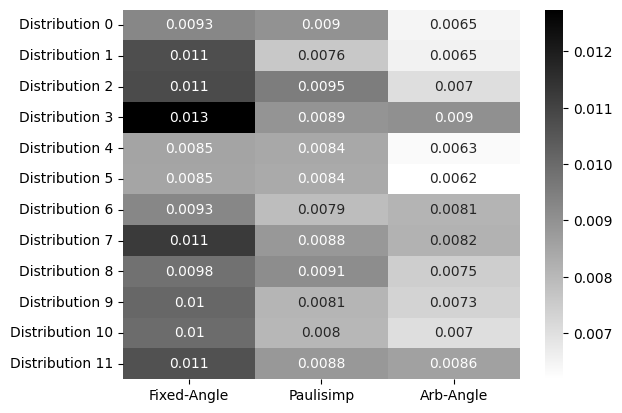

In [40]:
import seaborn as sns

sns.heatmap(df_jsd, annot=True, cmap="binary")

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>